# COVID Simulator - Return to Office

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Set Simulation Variables

In [2]:
# initialize variables
NumberOfAgents = 200
NumberOfDays = 365
ProbabilitySusceptible = 95
PreInfectedAgents = 5
LambdaInteractions = 10
ProbabilityInteractionAgent = NumberOfAgents
ProbabilityUnsafeInteraction = 2
ProbabilityHomeInfections = 0.3
MeanIncubationTime = 14
StandardDeviationIncubationTime = 2
LambdaRecoveryTime = 30
ProbabilityFatality = 1.5
NumberOfSimulationRuns = 10

## Step 2: Create Agent Records

Agent records will hold statistics and track the states of every individual agent for the simulation run.

In [3]:
# create agent records
def create_agent_records(NumberOfAgents,
                         ProbabilitySusceptible,
                         PreInfectedAgents,
                         MeanIncubationTime, # Incubation time is preset only used when infection occurs
                         StandardDeviationIncubationTime,
                         LambdaRecoveryTime, # Recovery time is preset only used when infection occurs
                         ProbabilityFatality # If fatal is true, recovery time is not considered, agent is inactive permanently
                        ):
    
    df_columns = ['id','active', 'susceptible', 
                  'infected', 'incubation_time', 'isolation_day',
                  'isolated', 'recovery_time', 'recovery_day',
                  'recovered', 'fatal']
    
    # Create agent records in DataFrame
    record_list = []
    for i in range (NumberOfAgents):
        agent_id = i
        agent_active = True
        agent_susceptible = (np.random.uniform(0, 100) <= ProbabilitySusceptible) # True or False susceptible
        agent_infected = ((np.random.uniform(0, 100) <= PreInfectedAgents) and agent_susceptible)
        agent_incubation_time = int(np.random.normal(MeanIncubationTime, StandardDeviationIncubationTime))
        agent_isolation_day = 0
        if agent_infected:
            agent_isolation_day = agent_incubation_time
        agent_isolated = False
        agent_recovery_time = int(np.random.exponential(LambdaRecoveryTime))
        agent_recovery_day = 0
        agent_recovered = False
        agent_fatal = (np.random.uniform(0, 100) <= ProbabilityFatality) # True or False fatal
        agent_record = [agent_id, agent_active, agent_susceptible,
                        agent_infected, agent_incubation_time, agent_isolation_day,
                        agent_isolated, agent_recovery_time, agent_recovery_day,
                        agent_recovered, agent_fatal
                       ]
        record_list.append(agent_record)
    df_agent_records = pd.DataFrame(record_list, columns=df_columns)
    return df_agent_records

In [4]:
# create the record to check
df_agent_records = create_agent_records(NumberOfAgents = NumberOfAgents,
                                         ProbabilitySusceptible = ProbabilitySusceptible,
                                         PreInfectedAgents = PreInfectedAgents,
                                         MeanIncubationTime = MeanIncubationTime, 
                                         StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                         LambdaRecoveryTime = LambdaRecoveryTime,
                                         ProbabilityFatality = ProbabilityFatality
                                        )

In [5]:
# show sample record
df_agent_records.head()

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,True,False,15,0,False,46,0,False,False
1,1,True,True,False,15,0,False,19,0,False,False
2,2,True,True,False,12,0,False,13,0,False,False
3,3,True,True,False,17,0,False,37,0,False,False
4,4,True,True,False,10,0,False,11,0,False,False


## Step 3: Run Simulation

Few Assumptions for simulation runs:
1. If agent is inactive or isolated, it will still be drawn in the interaction pool, but will be discarded, this compensates that if less people are at work the interactions will also diminish
2. If agent recovered, agent can not be infected again and can not be a carrier
3. Interactions that lead to infection are the ones an uninfected agent has with an infected agent and made an interaction mistake

In [6]:
def simulate_agent_infected(df_agent_records, agent_id, 
                            ProbabilityHomeInfections, LambdaInteractions, 
                            NumberOfAgents, ProbabilityUnsafeInteraction
                           ):
    agent_infected = False
    
    # agent infected at home?
    agent_infected = (np.random.uniform(0, 100) <= ProbabilityHomeInfections)
    
    # agent infected during interactions?
    number_of_interactions = int(np.random.poisson(LambdaInteractions)) # number of interactions
    agents_interactions_list = [int(x) for x in np.random.uniform(0, NumberOfAgents, number_of_interactions)] # agents
    infect_interactions_list = [1 if df_agent_records.infected[x] else 0 for x in agents_interactions_list] # infected agents
    unsafe_interactions_list = [1 if x <= ProbabilityUnsafeInteraction else 0 for 
                                x in np.random.uniform(0, 100, number_of_interactions)] # unsafe interactions
    result_list = [a and b for a, b in zip(infect_interactions_list, unsafe_interactions_list)] # cross infected and unsafe
    
    if sum(result_list):
        agent_infected = True
   
    return agent_infected

In [7]:
def simulate_day(NumberOfAgents, day_number, df_agent_records, 
                 ProbabilityHomeInfections, LambdaInteractions, 
                 ProbabilityUnsafeInteraction):
    # Check each agent
    df_agent_records_today = df_agent_records.copy()
    for i in range(NumberOfAgents):
        # 1. Agent Inactive or recovered, no actions
        if ((not df_agent_records_today.active[i]) 
            or (df_agent_records_today.recovered[i]) 
            or (not df_agent_records_today.susceptible[i])):
            continue
        
        # 2. Agent in Isolation, check if recovery is due
        if df_agent_records_today.isolated[i]:
            if (df_agent_records.recovery_day[i] == day_number):
                # data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100
                df_agent_records_today.loc[df_agent_records_today.id == i, 'recovered'] = True
                df_agent_records_today.loc[df_agent_records_today.id == i, 'isolated'] = False
            continue
        
        # 3. Agent is Infected, check if isolation is due
        if df_agent_records_today.infected[i]:
            if (df_agent_records_today.isolation_day[i] == day_number):
                # check fatality
                if df_agent_records_today.fatal[i]:
                    df_agent_records_today.loc[df_agent_records_today.id == i, 'active'] = False
                    # no longer infection threat as agent isolated from employees
                df_agent_records_today.loc[df_agent_records_today.id == i, 'isolated'] = True
                df_agent_records_today.loc[df_agent_records_today.id == i, 'infected'] = False
                recovery_day = df_agent_records_today.recovery_time[i] + day_number
                df_agent_records_today.loc[df_agent_records_today.id == i, 'recovery_day'] = recovery_day
                
            continue
            
        # 4. Agent is healty, simulate day
        agent_infected = simulate_agent_infected(df_agent_records=df_agent_records, # send previous day record!
                                                 agent_id=i, 
                                                 ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                                 LambdaInteractions=LambdaInteractions,
                                                 NumberOfAgents=NumberOfAgents,
                                                 ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                                                ) 
    
        if agent_infected:
            df_agent_records_today.loc[df_agent_records_today.id == i, 'infected'] = True
            isolation_day = df_agent_records_today.incubation_time[i] + day_number
            df_agent_records_today.loc[df_agent_records_today.id == i, 'isolation_day'] = isolation_day
            
    return df_agent_records_today # todays record

In [8]:
# Show one day
df_one_day = simulate_day(NumberOfAgents=NumberOfAgents, 
                          day_number=1, 
                          df_agent_records=df_agent_records,
                          ProbabilityHomeInfections=ProbabilityHomeInfections, 
                          LambdaInteractions=LambdaInteractions, 
                          ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)
# First 10 start as infected, as set in the variables, regardles susceptible
df_one_day.head(5)

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,True,False,15,0,False,46,0,False,False
1,1,True,True,False,15,0,False,19,0,False,False
2,2,True,True,False,12,0,False,13,0,False,False
3,3,True,True,False,17,0,False,37,0,False,False
4,4,True,True,False,10,0,False,11,0,False,False


In [9]:
def simulation_run(NumberOfDays = NumberOfDays,
                   NumberOfAgents = NumberOfAgents,
                   ProbabilitySusceptible = ProbabilitySusceptible,
                   PreInfectedAgents = PreInfectedAgents,
                   MeanIncubationTime = MeanIncubationTime, 
                   StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                   LambdaRecoveryTime = LambdaRecoveryTime,
                   ProbabilityFatality = ProbabilityFatality,
                   ProbabilityHomeInfections=ProbabilityHomeInfections, 
                   LambdaInteractions=LambdaInteractions, 
                   ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                  ):
    # Create Agent Records
    df_agent_records = create_agent_records(NumberOfAgents = NumberOfAgents,
                                         ProbabilitySusceptible = ProbabilitySusceptible,
                                         PreInfectedAgents = PreInfectedAgents,
                                         MeanIncubationTime = MeanIncubationTime, 
                                         StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                         LambdaRecoveryTime = LambdaRecoveryTime,
                                         ProbabilityFatality = ProbabilityFatality
                                        )
    # Simulate number of days
    df_agent_records_today = df_agent_records.copy()
    sim_days_list = []
    sim_days_list.append(df_agent_records_today)
    for day_number in range(1, NumberOfDays+1): #starting day 1
        df_agent_records_today = simulate_day(NumberOfAgents=NumberOfAgents, 
                                              day_number=day_number, 
                                              df_agent_records=df_agent_records_today,
                                              ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                              LambdaInteractions=LambdaInteractions, 
                                              ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)
    
        sim_days_list.append(df_agent_records_today)
    return sim_days_list

In [10]:
# Check single Run
daily_records_list_single_run = simulation_run(NumberOfDays = NumberOfDays,
                                               NumberOfAgents = NumberOfAgents,
                                               ProbabilitySusceptible = ProbabilitySusceptible,
                                               PreInfectedAgents = PreInfectedAgents,
                                               MeanIncubationTime = MeanIncubationTime, 
                                               StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                               LambdaRecoveryTime = LambdaRecoveryTime,
                                               ProbabilityFatality = ProbabilityFatality,
                                               ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                               LambdaInteractions=LambdaInteractions, 
                                               ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                                              )

In [11]:
# Show a record
df_one_record = daily_records_list_single_run[4] # example day 4
df_one_record.head(20)

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,True,False,15,0,False,40,0,False,False
1,1,True,True,False,15,0,False,29,0,False,False
2,2,True,True,False,12,0,False,53,0,False,False
3,3,True,True,False,16,0,False,1,0,False,False
4,4,True,True,False,10,0,False,12,0,False,False
5,5,True,True,True,9,9,False,0,0,False,False
6,6,True,True,False,14,0,False,17,0,False,False
7,7,True,True,False,14,0,False,83,0,False,False
8,8,True,True,False,11,0,False,18,0,False,False
9,9,True,True,False,13,0,False,40,0,False,False


### Full Simulation

In [12]:
def full_simulation(NumberOfDays = NumberOfDays,
                    NumberOfAgents = NumberOfAgents,
                    NumberOfSimulationRuns = NumberOfSimulationRuns,
                    ProbabilitySusceptible = ProbabilitySusceptible,
                    PreInfectedAgents = PreInfectedAgents,
                    MeanIncubationTime = MeanIncubationTime, 
                    StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                    LambdaRecoveryTime = LambdaRecoveryTime,
                    ProbabilityFatality = ProbabilityFatality,
                    ProbabilityHomeInfections=ProbabilityHomeInfections, 
                    LambdaInteractions=LambdaInteractions, 
                    ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction):
    simulation_list = []
    for i in range(NumberOfSimulationRuns):
        print("Simulation Run: ", i)
        sim_days_list = simulation_run(NumberOfDays = NumberOfDays,
                                       NumberOfAgents = NumberOfAgents,
                                       ProbabilitySusceptible = ProbabilitySusceptible,
                                       PreInfectedAgents = PreInfectedAgents,
                                       MeanIncubationTime = MeanIncubationTime, 
                                       StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                       LambdaRecoveryTime = LambdaRecoveryTime,
                                       ProbabilityFatality = ProbabilityFatality,
                                       ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                       LambdaInteractions=LambdaInteractions, 
                                       ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction
                                      )
        simulation_list.append(sim_days_list)
    return simulation_list

In [13]:
simulation_results =full_simulation(NumberOfDays = NumberOfDays,
                                    NumberOfAgents = NumberOfAgents,
                                    NumberOfSimulationRuns = NumberOfSimulationRuns,
                                    ProbabilitySusceptible = ProbabilitySusceptible,
                                    PreInfectedAgents = PreInfectedAgents,
                                    MeanIncubationTime = MeanIncubationTime, 
                                    StandardDeviationIncubationTime = StandardDeviationIncubationTime,
                                    LambdaRecoveryTime = LambdaRecoveryTime,
                                    ProbabilityFatality = ProbabilityFatality,
                                    ProbabilityHomeInfections=ProbabilityHomeInfections, 
                                    LambdaInteractions=LambdaInteractions, 
                                    ProbabilityUnsafeInteraction=ProbabilityUnsafeInteraction)

Simulation Run:  0
Simulation Run:  1
Simulation Run:  2
Simulation Run:  3
Simulation Run:  4
Simulation Run:  5
Simulation Run:  6
Simulation Run:  7
Simulation Run:  8
Simulation Run:  9


## Step 4: Analytics and Visualization

### Check Single Days

In [14]:
df_one_record = simulation_results[0][223] # status of agents from first simulation [0], day 223 [223]
df_one_record.head(20)

,id,active,susceptible,infected,incubation_time,isolation_day,isolated,recovery_time,recovery_day,recovered,fatal
0,0,True,True,False,16,16,False,4,20,True,False
1,1,True,True,False,13,28,False,1,29,True,False
2,2,True,True,False,12,34,False,61,95,True,False
3,3,True,True,False,13,33,False,6,39,True,False
4,4,True,True,False,15,168,False,37,205,True,False
5,5,True,True,False,11,0,False,41,0,False,False
6,6,True,True,False,15,35,False,11,46,True,False
7,7,True,True,False,9,9,False,19,28,True,False
8,8,True,True,False,9,18,False,9,27,True,False
9,9,True,True,False,14,29,False,8,37,True,False


### Single Run Example

In [15]:
def count_column_boolean(df_list, column_name):
    true_count_list = []
    for i in range(len(df_list)):
        df = df_list[i]
        true_count = df[column_name].sum()
        true_count_list.append(true_count)
    return true_count_list  

In [16]:
# Single Run Example
df_list = simulation_results[0] # chose a simulation result
# Retrieve statistics from records, counting True in status columns
number_days = len(df_list)
x1 = list(range(0, number_days))
tc_active = count_column_boolean(df_list=df_list, column_name='active')
tc_infected = count_column_boolean(df_list=df_list, column_name='infected')
tc_isolated = count_column_boolean(df_list=df_list, column_name='isolated')
tc_recovered = count_column_boolean(df_list=df_list, column_name='recovered')
tc_fatal = [NumberOfAgents-x for x in tc_active]
tc_workforce_inactive = [x + y for x, y in zip(tc_isolated, tc_fatal)]
tc_workforce_active = [NumberOfAgents-x for x in tc_workforce_inactive]

In [17]:
# Set Font Size for Plotting
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15,15]

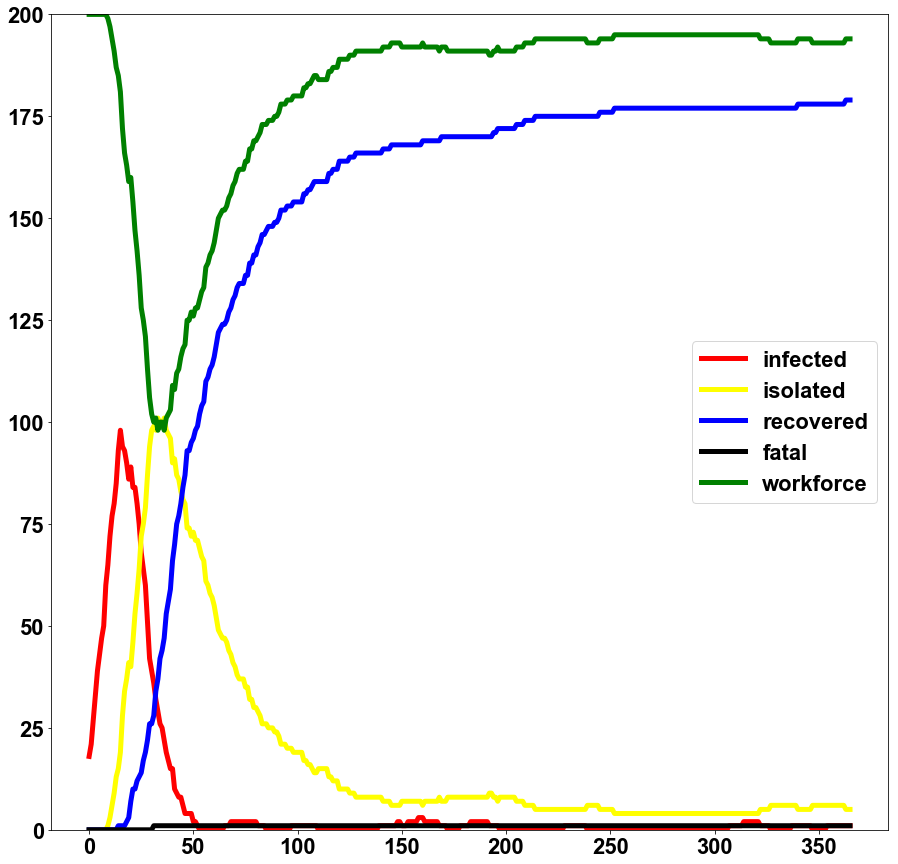

In [18]:
# Plot the data
# Prepare the data
x = x1
y1 = tc_infected
y2 = tc_isolated
y3 = tc_recovered
y4 = tc_fatal
y5 = tc_workforce_active
plt.ylim(top = NumberOfAgents, bottom = 0)
y_ticks = range(NumberOfAgents+1)
#plt.subplot(1, 4, 4)
plt.ylim(top = NumberOfAgents, bottom = 0)
#plt.yticks(y_ticks)
plt.plot(x, y1, label='infected', lw=5.0, color='red')
plt.plot(x, y2, label='isolated', lw=5.0, color='yellow')
plt.plot(x, y3, label='recovered', lw=5.0, color='blue')
plt.plot(x, y4, label='fatal', lw=5.0, color='black')
plt.plot(x, y5, label='workforce', lw=5.0, color='green')
plt.legend()
# Show the plots
plt.show()